In [413]:
import json
import plotly
from ipywidgets import interact, interactive, fixed, interact_manual
from pprint import pprint
 
def simplify_config(game_config: dict) -> dict:
    simple_config = {}
    for config in game_config:
        simple_config[config["NativeClass"]] = {item["ClassName"]: item for item in config["Classes"]}
    return simple_config

CONFIG_LOCATION = "D:\SteamLibrary\steamapps\common\Satisfactory\CommunityResources\Docs\Docs.json"
with open(CONFIG_LOCATION, "r", encoding="utf-16") as f:
    data = f.read()
    BASE_CONFIG = simplify_config(json.loads(data))
    
def standardize(value: str):
    return "_".join(value.replace("-", "_").replace(":", "").split()).lower()

# missing miner, rebar spreadshot
RESOURCE_KEYS = ("Class'/Script/FactoryGame.FGItemDescriptor'", 
                 "Class'/Script/FactoryGame.FGResourceDescriptor'",
                 "Class'/Script/FactoryGame.FGConsumableDescriptor'",
                 "Class'/Script/FactoryGame.FGItemDescriptorBiomass'",
                 "Class'/Script/FactoryGame.FGAmmoTypeProjectile'",
                 "Class'/Script/FactoryGame.FGItemDescriptorNuclearFuel'",
                 "Class'/Script/FactoryGame.FGAmmoTypeInstantHit'")

In [423]:
data.find("BP_ItemDescriptorPortableMiner_C")

188327

In [426]:
data[188327 + 10:].find("BP_ItemDescriptorPortableMiner_C")

4961

In [429]:
data[188327 + 10 + 4961:].find("BP_ItemDescriptorPortableMiner_C")

0

In [428]:
data[188327 + 4961 - 800:188327 + 4961 + 500]

'ufacturingMultiplier":"1.000000","mProducedIn":"(/Game/FactoryGame/Equipment/BuildGun/BP_BuildGun.BP_BuildGun_C)","mRelevantEvents":"","mVariablePowerConsumptionConstant":"0.000000","mVariablePowerConsumptionFactor":"1.000000"},{"ClassName":"Recipe_PortableMiner_C","FullName":"BlueprintGeneratedClass /Game/FactoryGame/Recipes/Equipment/Recipe_PortableMiner.Recipe_PortableMiner_C","mDisplayName":"Portable Miner","mIngredients":"((ItemClass=BlueprintGeneratedClass\'\\"/Game/FactoryGame/Resource/Parts/IronPlate/Desc_IronPlate.Desc_IronPlate_C\\"\',Amount=2),(ItemClass=BlueprintGeneratedClass\'\\"/Game/FactoryGame/Resource/Parts/IronRod/Desc_IronRod.Desc_IronRod_C\\"\',Amount=4))","mProduct":"((ItemClass=BlueprintGeneratedClass\'\\"/Game/FactoryGame/Resource/Equipment/PortableMiner/BP_ItemDescriptorPortableMiner.BP_ItemDescriptorPortableMiner_C\\"\',Amount=1))","mManufacturingMenuPriority":"0.000000","mManufactoringDuration":"40.000000","mManualManufacturingMultiplier":"1.000000","mProduc

In [415]:
# TODO: make an intermediate config with cleaned up keys
# material/recipe: internal_name: useful info
import itertools

def get_materials(simple_config: dict) -> list[str]:

    resources = []
    for item in itertools.chain.from_iterable((simple_config[key].values() for key in RESOURCE_KEYS)):
        resources.append(standardize(item["mDisplayName"]))
    return resources

In [416]:
BASE_CONFIG["Class'/Script/FactoryGame.FGAmmoTypeInstantHit'"]

{'Desc_CartridgeChaos_C': {'ClassName': 'Desc_CartridgeChaos_C',
  'Location': '(X=0.000000,Y=0.000000,Z=0.000000)',
  'Trail_Velocity': '7555.000000',
  'mPlayFireEffects': 'True',
  'AmmoFiredDelegate': '()',
  'mFiringTransform': '(Rotation=(X=-0.007296,Y=-0.012003,Z=-0.519339,W=0.854453),Translation=(X=1763.678467,Y=8088.381836,Z=1104.262939),Scale3D=(X=1.000000,Y=1.000000,Z=1.000000))',
  'mFiringDirection': '(X=0.000000,Y=0.000000,Z=0.000000)',
  'mMagazineSize': '75',
  'mMaxAmmoEffectiveRange': '10000.000000',
  'mReloadTimeMultiplier': '1.000000',
  'mFireRate': '0.400000',
  'mFiringTransformIgnoresDispersion': 'False',
  'mDispersionFireRateMultiplier': '5.000000',
  'mDispersionPerShot': '0.200000',
  'mRestingDispersion': '0.000000',
  'mFiringDispersion': '5.000000',
  'mDispersionRecoveryTime': '2.500000',
  'mHasBeenInitialized': 'True',
  'mWeaponDamageMultiplier': '1.000000',
  'mMagazineMeshMaterials': '((MaterialInterface=MaterialInstanceConstant\'"/Game/FactoryGame

In [565]:
from abc import ABC
from dataclasses import dataclass, fields, make_dataclass
from enum import Enum, auto
from collections import deque
from typing import Optional
from itertools import zip_longest

# TODO: how much of this can be expressed/solved with matrices?

class ConfigurationError(Exception):
    pass

class __MaterialSpec:
    """
    TODO: give this a widget
    """    
    def __add__(self, other):
        if not isinstance(other, type(self)):
            return NotImplemented
        
        result = {}
        for name, value in self:
            result[name] = value + getattr(other, name)
        return type(self)(**result)
    
    def __sub__(self, other):
        if not isinstance(other, type(self)):
            return NotImplemented
        
        result = {}
        for name, value in self:
            result[name] = value - getattr(other, name)
        return type(self)(**result)
    
    def __mul__(self, scalar):
        result = {}
        for name, value in self:
            result[name] = value * scalar 
        return type(self)(**result)
    
    def __iter__(self):
        for f in fields(self):
            yield f.name, getattr(self, f.name)
                       
    def __or__(self, other):
        if isinstance(other, type(self)):
            return type(self)(**{name: value for (name, value), (_, matched_value) in zip(self, other) if matched_value > 0})
        elif isinstance(other, Material):
            return type(self)(**{other.name: getattr(self, other.name)})
        elif isinstance(other, str):
            return type(self)(**{other: getattr(self, other)})
        
        return NotImplemented
    
    def __str__(self):
        return "\n".join(f"{name}: {value}" for name, value in self if value > 0)

MaterialSpec = make_dataclass("MaterialSpec", [(mat, float, 0) for mat in get_materials(BASE_CONFIG)], bases=(__MaterialSpec,))
    
class Recipe:
    def __init__(self, ingredients: MaterialSpec, products: MaterialSpec):
        self.ingredients = ingredients
        self.products = products
        
    def __add__(self, material_spec: MaterialSpec):
        return material_spec + self.products - self.ingredients
    
    def __radd__(self, material_spec: MaterialSpec):
        return self + material_spec
    
    def __rsub__(self, material_spec: MaterialSpec):
        return material_spec + self.ingredients - self.products
    
    def __mul__(self, scalar: float):
        """
        Scale up this recipe
        """
        return type(self)(self.ingredients * scalar, self.products * scalar)
    
    def __rtruediv__(self, material_spec: MaterialSpec):
        """
        Get the number of iterations of this recipe that can be produced from the given material_spec
        """
        return min(getattr(material_spec, name) / value for name, value in self.ingredients if value > 0)
    
    def __str__(self):
        ingredients = " ".join(str(self.ingredients).splitlines())
        products = " ".join(str(self.products).splitlines())
                
        return f"{ingredients} >> {products}"
        
        
class Machine(ABC):
    available_recipes: list[Recipe]
    input_producers: dict["Self", Material]
    output_consumers: dict["Self", Material]
    
    power_consumption: float
    inputs: int
    outputs: int
    
    def __init__(self, recipe: Recipe):
        inputs = sum(material > 0 for _, material in recipe.ingredients)
        outputs = sum(material > 0 for _, material in recipe.products)
        self.input_producers = {}
        self.output_consumers = {}
        
        if inputs != self.inputs or outputs != self.outputs:
            raise ConfigurationError(f"{self.__class__} must have {self.inputs} inputs and {self.outputs} outputs")
            
        self.recipe = recipe
        
    def __init_subclass__(cls, *args, **kwargs):
        super().__init_subclass__(*args, **kwargs)
        cls.available_recipes = []
        
    def __rshift__(self, material_spec: MaterialSpec):
        """
        Solve for inputs
        Recipe >> MaterialSpec
        """
        # TODO: what should the inverse of div be?
        scale = max(getattr(material_spec, name) / value for name, value in self.recipe.products if value > 0)
        scaled = self.recipe * scale
        return material_spec - scaled
    
    def __lshift__(self, material_spec: MaterialSpec):
        """
        Solve for outputs
        Recipe << MaterialSpec
        """
        scale = material_spec / self.recipe
        scaled = self.recipe * scale
        return material_spec + scaled
        
    def __rrshift__(self, material_spec: MaterialSpec):
        """
        Solve for inputs
        MaterialSpec << Recipe
        """
        return self << material_spec
    
    def __rlshift__(self, material_spec: MaterialSpec):
        """
        Solve for outputs
        MaterialSpec >> Recipe
        """
        return self >> material_spec
        
    def has_input(self, material: Material):
        return getattr(self.recipe.ingredients, material) > 0
    
    def has_output(self, material: Material):
        return getattr(self.recipe.products, material) > 0
    
    def bind(self, other: "Machine", material: Material):
        """
        Verify that there is a matching input-output pair for these two machines
        
        # TODO: can only handle binding one output to a given machine
        """
        if self.has_output(material) and other.has_input(material):
            other.input_producers[self] = material
            self.output_consumers[other] = material
        elif self.has_input(material) and other.has_output(material):
            self.input_producers[other] = material
            other.output_consumers[self] = material
        else:
            raise ConfigurationError(f"{self} and {other} do not have a matching input and output.")
            
        return self
    
    
class ProcessSpec:
    """
    TODO: power
    """
    scale: int
    power: float = 0
    process_root: Machine
    input_materials: MaterialSpec
    output_materials: MaterialSpec
    surplus_materials: MaterialSpec
    process_registry = {}
    
    def __init__(self, process_root: Machine, target_output: MaterialSpec=None):
        # TODO: scale process to desired output
        self.process_root = process_root
        
        if len(self.process_root.output_consumers) > 0:
            required_output = sum((self.process_registry[output_consumer].input_materials | bound_material for output_consumer, bound_material in process_root.output_consumers.items()), MaterialSpec())
            self.input_materials = (process_root >> required_output) | process_root.recipe.ingredients
        else:
            required_output = process_root.recipe.products if target_output is None else target_output | process_root.recipe.products
            self.input_materials = process_root >> required_output
            self.process_registry[process_root] = self
            
        for subprocess in process_root.input_producers:
            if subprocess not in self.process_registry:
                self.process_registry[subprocess] = type(self)(subprocess)
             
        raw_output = self.input_materials >> process_root
        self._required = required_output # for debugging
        self._raw = raw_output
        self.output_materials = raw_output | required_output
        self.surplus_materials = raw_output - required_output
        self.scale = self.input_materials / process_root.recipe
        
    def __str__(self):
        return (f"Type    |  {self.process_root.__class__.__name__}<br>"
                f"Recipe  |  {self.process_root.recipe}<br>"
                f"Scale   |  {self.scale}<br>")


class VariableOutputMachine(Machine):
        
    def __init__(self, recipe: Recipe):
        self.outputs = min(sum(material > 0 for _, material in recipe.products), self.outputs)
        
        super().__init__(recipe)
        
class VariableInputMachine(Machine):
        
    def __init__(self, recipe: Recipe):
        self.inputs = min(sum(material > 0 for _, material in recipe.ingredients), self.inputs)
        
        super().__init__(recipe)
        
# class Extractor(Machine):
#     inputs = 0
#     outputs = 1                                                                                  
    
class Constructor(Machine):
    power_consumption = 300
    inputs = 1
    outputs = 1
    
class Assembler(Machine):
    power_consumption = 300
    inputs = 2
    outputs = 1
    
class Manufacturer(VariableInputMachine):
    power_consumption = 300
    inputs = 4
    outputs = 1
    
class Smelter(Machine):
    power_consumption = 300
    inputs = 1
    outputs = 1
    
class Foundry(Machine):
    power_consumption = 300 
    inputs = 2
    outputs = 1
    
class Packager(VariableOutputMachine, VariableInputMachine):
    power_consumption = 300
    inputs = 2
    outputs = 2
    
class Refinery(VariableOutputMachine, VariableInputMachine):
    power_consumption = 300
    inputs = 2
    outputs = 2
    
class Aggregator(VariableOutputMachine, VariableInputMachine):
    """
    Special class to join disjoint trees so that every process can be expressed as a tree, regardless of desired outputs. Can be used, for example, to represent a factory floor as a 'Machine'
    """
    pass

    
# class Blender(Machine):
#     pass


# TODO: merge/split machines producing the same item
# TODO: dummy machine to create tree from disjoint processes

# def optimize_recipe(recipe: Recipe, weights: MaterialSpec):
#     # TODO: consider power
#     # TODO: this will likely be most efficient with pre-processing of the costs of various sub-processes
#     pass

In [566]:
import re

machine_mapping = {"/Game/FactoryGame/Buildable/Factory/AssemblerMk1/Build_AssemblerMk1.Build_AssemblerMk1_C": Assembler, 
 "/Game/FactoryGame/Buildable/Factory/ManufacturerMk1/Build_ManufacturerMk1.Build_ManufacturerMk1_C": Manufacturer, 
 "/Game/FactoryGame/Buildable/Factory/SmelterMk1/Build_SmelterMk1.Build_SmelterMk1_C": Smelter,
 "/Game/FactoryGame/Buildable/Factory/ConstructorMk1/Build_ConstructorMk1.Build_ConstructorMk1_C": Constructor, 
 "/Game/FactoryGame/Buildable/Factory/FoundryMk1/Build_FoundryMk1.Build_FoundryMk1_C": Foundry,
 # "/Game/FactoryGame/Buildable/Factory/HadronCollider/Build_HadronCollider.Build_HadronCollider_C",
 "/Game/FactoryGame/Buildable/Factory/Packager/Build_Packager.Build_Packager_C": Packager,
 "/Game/FactoryGame/Buildable/Factory/OilRefinery/Build_OilRefinery.Build_OilRefinery_C": Refinery}

def make_recipes(simple_config: dict, machine_mapping: dict[str, Machine]) -> list:
    ingredients_pattern = r"\(ItemClass=.*?\.(\w+).*?,Amount=(\d+)\)"
    machines_pattern = fr"({'|'.join(re.escape(m) for m in machine_mapping.keys())})"
    known_crafters = ("Smelter", "Manufacturer", "Assembler", "Packager", "Refinery", "Collider", "Foundry", "Blender", "Constructor")
    
    machines = {}
    material_config = {}
    for key in RESOURCE_KEYS:
        material_config.update(simple_config[key])

    for config in simple_config["Class'/Script/FactoryGame.FGRecipe'"].values():
        machine = re.search(machines_pattern, config["mProducedIn"])
        
        if machine is None:
            continue

        machine = machine_mapping[machine[0]]
            
        # TODO: convert resources to friendly names
        try:
            ingredients = {standardize(material_config[name]["mDisplayName"]): int(amt) for name, amt in re.findall(ingredients_pattern, config["mIngredients"])}
            products = {standardize(material_config[name]["mDisplayName"]): int(amt) for name, amt in re.findall(ingredients_pattern, config["mProduct"])}
            machines[standardize(config["mDisplayName"])] = machine(Recipe(MaterialSpec(**ingredients), MaterialSpec(**products)))
        except Exception as e:
            print(f"missing: {e}")
            print(config)
            print()
        
    return machines

In [567]:
available_machines = dict(sorted(make_recipes(BASE_CONFIG, machine_mapping).items()))
available_machines

missing: 'BP_ItemDescriptorPortableMiner_C'
{'ClassName': 'Recipe_Alternate_AutomatedMiner_C', 'FullName': 'BlueprintGeneratedClass /Game/FactoryGame/Recipes/AlternateRecipes/New_Update4/Recipe_Alternate_AutomatedMiner.Recipe_Alternate_AutomatedMiner_C', 'mDisplayName': 'Alternate: Automated Miner', 'mIngredients': '((ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/Motor/Desc_Motor.Desc_Motor_C"\',Amount=1),(ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/SteelPipe/Desc_SteelPipe.Desc_SteelPipe_C"\',Amount=4),(ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/IronRod/Desc_IronRod.Desc_IronRod_C"\',Amount=4),(ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/IronPlate/Desc_IronPlate.Desc_IronPlate_C"\',Amount=2))', 'mProduct': '((ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Equipment/PortableMiner/BP_ItemDescriptorPortableMiner.BP_ItemDescriptorPortableMiner_C"\',Amount=1))', 'mManufacturin

{'actual_snow': <__main__.Constructor at 0x2d4555d1190>,
 'adaptive_control_unit': <__main__.Manufacturer at 0x2d454b639d0>,
 'ai_limiter': <__main__.Assembler at 0x2d454b550d0>,
 'alclad_aluminum_sheet': <__main__.Assembler at 0x2d456178670>,
 'alternate_adhered_iron_plate': <__main__.Assembler at 0x2d455737e50>,
 'alternate_alclad_casing': <__main__.Assembler at 0x2d459a85910>,
 'alternate_automated_speed_wiring': <__main__.Manufacturer at 0x2d454b639a0>,
 'alternate_biocoal': <__main__.Constructor at 0x2d4561d6940>,
 'alternate_bolted_frame': <__main__.Assembler at 0x2d454ad89d0>,
 'alternate_bolted_iron_plate': <__main__.Assembler at 0x2d4556e7b20>,
 'alternate_cast_screw': <__main__.Constructor at 0x2d4555d7a30>,
 'alternate_caterium_circuit_board': <__main__.Assembler at 0x2d455642070>,
 'alternate_caterium_computer': <__main__.Manufacturer at 0x2d455642ac0>,
 'alternate_caterium_wire': <__main__.Constructor at 0x2d454a558e0>,
 'alternate_charcoal': <__main__.Constructor at 0x2d4

In [568]:
target_product = MaterialSpec(steel_pipe=60)
process = available_machines["steel_pipe"].bind(available_machines["steel_ingot"], "steel_ingot")
solution = ProcessSpec(process, target_product)

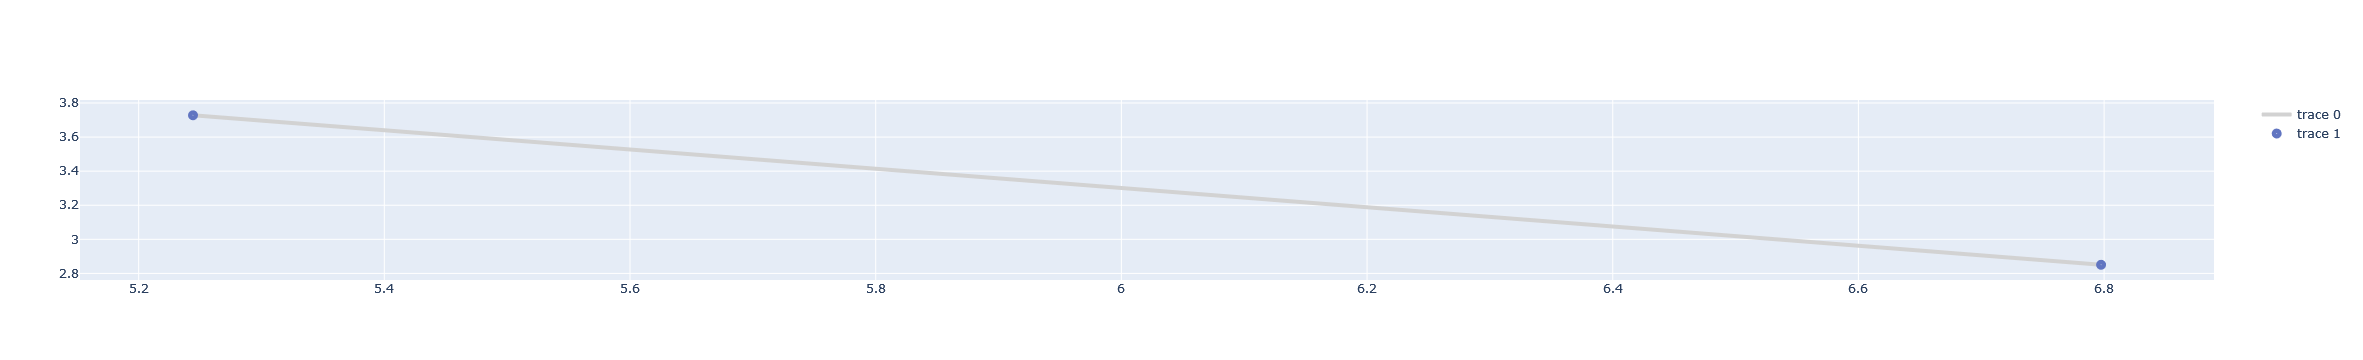

In [569]:
import igraph
from igraph import Graph, EdgeSeq
import itertools
import plotly.graph_objects as go

n_vertices = len(solution.process_registry)
ordered_vertices = list(solution.process_registry.keys())
# setup all edges as 
edges = [(ordered_vertices.index(self), ordered_vertices.index(other)) for self in ordered_vertices for other in self.input_producers]

G = Graph(n_vertices, edges)
layout = G.layout(Graph.layout_davidson_harel)
Xn, Yn = list(zip(*layout))
edge_coords = itertools.chain.from_iterable([[(Xn[n], Yn[n]) for n in e] + [(None, None)] for e in edges])
Xe, Ye = list(zip(*edge_coords))

fig = go.Figure()
fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgba(210,210,210, 255)', width=4),
                   hoverinfo='none'
                   ))
fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  marker=dict(symbol='circle-dot',
                                size=10, # TODO: size by node scale
                                color='#6175c1',    #'#DB4551',
                            ),
                  text=[solution.process_registry[m] for m in ordered_vertices],
                  hovertemplate="%{text}"
                  ))

# TODO: show ratio on trace

In [ ]:
# graph

In [93]:
# sunburst

In [94]:
#sankey